In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm  # For progress bars

In [60]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [61]:
# Data transformations
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [62]:
# Load datasets
train_dataset = datasets.ImageFolder(
    root="C:/Users/swind/OneDrive/Desktop/SENG-460/FER2013/train",
    transform=train_transform
)

test_dataset = datasets.ImageFolder(
    root="C:/Users/swind/OneDrive/Desktop/SENG-460/FER2013/test",
    transform=test_transform
)

# Split train into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [63]:
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        
        # Block 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.25)
        
        # Block 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(0.25)
        
        # Block 3
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)
        self.dropout3 = nn.Dropout(0.25)
        
        # Block 4
        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2)
        self.dropout4 = nn.Dropout(0.25)
        
        # Calculate flattened dimension
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 48, 48)
            dummy = self.pool1(self.bn2(self.conv2(self.bn1(self.conv1(dummy)))))
            dummy = self.pool2(self.bn4(self.conv4(self.bn3(self.conv3(dummy)))))
            dummy = self.pool3(self.bn6(self.conv6(self.bn5(self.conv5(dummy)))))
            dummy = self.pool4(self.bn8(self.conv8(self.bn7(self.conv7(dummy)))))
            self.flat_dim = dummy.numel()  # Total number of elements
            
        # Fully connected layers
        self.fc1 = nn.Linear(self.flat_dim, 256)
        self.bn9 = nn.BatchNorm1d(256)
        self.dropout5 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 7)
        
    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Block 3
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Block 4
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.pool4(x)
        x = self.dropout4(x)
        
        # Fully connected
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.bn9(self.fc1(x)))
        x = self.dropout5(x)
        x = self.fc2(x)
        
        return x

In [64]:
# Model definition (using the EmotionCNN we defined earlier)
model = EmotionCNN().to(device)

In [65]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)

c:\Users\swind\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [66]:
# Training function
def train_model(epochs):
    best_val_acc = 0.0
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        # Wrap train_loader with tqdm for progress bar
        train_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
        
        for inputs, labels in train_iter:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()
            
            # Update progress bar
            train_iter.set_postfix(loss=loss.item())
        
        train_acc = 100. * correct_train / total_train
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            val_iter = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False)
            for inputs, labels in val_iter:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()
                
                val_iter.set_postfix(loss=loss.item())
        
        val_acc = 100. * correct_val / total_val
        avg_val_loss = val_loss / len(val_loader)
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        
        # Print epoch statistics
        print(f"\nEpoch {epoch+1}/{epochs}:")
        print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"New best model saved with val accuracy: {val_acc:.2f}%")
    
    print(f"\nTraining complete. Best validation accuracy: {best_val_acc:.2f}%")

# Run training
train_model(epochs=100)

# Final test evaluation
def evaluate_test():
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        test_iter = tqdm(test_loader, desc="Testing")
        for inputs, labels in test_iter:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()
    
    test_acc = 100. * correct_test / total_test
    avg_test_loss = test_loss / len(test_loader)
    
    print(f"\nFinal Test Results:")
    print(f"Test Loss: {avg_test_loss:.4f} | Test Acc: {test_acc:.2f}%")

evaluate_test()


Epoch 1/100:
Train Loss: 1.8727 | Train Acc: 23.02%
Val Loss: 1.8206 | Val Acc: 27.57%
New best model saved with val accuracy: 27.57%



Epoch 2/100:
Train Loss: 1.7513 | Train Acc: 29.83%
Val Loss: 1.8334 | Val Acc: 30.76%
New best model saved with val accuracy: 30.76%



Epoch 3/100:
Train Loss: 1.6500 | Train Acc: 34.91%
Val Loss: 1.6152 | Val Acc: 38.30%
New best model saved with val accuracy: 38.30%



Epoch 4/100:
Train Loss: 1.5591 | Train Acc: 39.21%
Val Loss: 1.5397 | Val Acc: 41.19%
New best model saved with val accuracy: 41.19%



Epoch 5/100:
Train Loss: 1.4912 | Train Acc: 42.33%
Val Loss: 1.4569 | Val Acc: 43.83%
New best model saved with val accuracy: 43.83%



Epoch 6/100:
Train Loss: 1.4374 | Train Acc: 44.30%
Val Loss: 1.3700 | Val Acc: 47.81%
New best model saved with val accuracy: 47.81%



Epoch 7/100:
Train Loss: 1.3909 | Train Acc: 46.41%
Val Loss: 1.3310 | Val Acc: 48.87%
New best model saved with val accuracy: 48.87%



Epoch 8/100:
Train Loss: 1.3509 | Train Acc: 48.51%
Val Loss: 1.2925 | Val Acc: 50.49%
New best model saved with val accuracy: 50.49%



Epoch 9/100:
Train Loss: 1.3160 | Train Acc: 49.55%
Val Loss: 1.2495 | Val Acc: 51.27%
New best model saved with val accuracy: 51.27%



Epoch 10/100:
Train Loss: 1.2926 | Train Acc: 50.91%
Val Loss: 1.2426 | Val Acc: 52.30%
New best model saved with val accuracy: 52.30%



Epoch 11/100:
Train Loss: 1.2563 | Train Acc: 51.97%
Val Loss: 1.2288 | Val Acc: 53.43%
New best model saved with val accuracy: 53.43%



Epoch 12/100:
Train Loss: 1.2432 | Train Acc: 52.51%
Val Loss: 1.1805 | Val Acc: 55.02%
New best model saved with val accuracy: 55.02%



Epoch 13/100:
Train Loss: 1.2244 | Train Acc: 53.39%
Val Loss: 1.1739 | Val Acc: 55.15%
New best model saved with val accuracy: 55.15%



Epoch 14/100:
Train Loss: 1.2002 | Train Acc: 54.25%
Val Loss: 1.1625 | Val Acc: 55.36%
New best model saved with val accuracy: 55.36%



Epoch 15/100:
Train Loss: 1.1840 | Train Acc: 55.10%
Val Loss: 1.1931 | Val Acc: 54.39%



Epoch 16/100:
Train Loss: 1.1737 | Train Acc: 55.54%
Val Loss: 1.1448 | Val Acc: 56.43%
New best model saved with val accuracy: 56.43%



Epoch 17/100:
Train Loss: 1.1591 | Train Acc: 55.96%
Val Loss: 1.1385 | Val Acc: 56.43%



Epoch 18/100:
Train Loss: 1.1513 | Train Acc: 56.34%
Val Loss: 1.1339 | Val Acc: 55.87%



Epoch 19/100:
Train Loss: 1.1351 | Train Acc: 56.99%
Val Loss: 1.1508 | Val Acc: 56.37%



Epoch 20/100:
Train Loss: 1.1267 | Train Acc: 57.37%
Val Loss: 1.1105 | Val Acc: 57.38%
New best model saved with val accuracy: 57.38%



Epoch 21/100:
Train Loss: 1.1144 | Train Acc: 57.58%
Val Loss: 1.1086 | Val Acc: 58.03%
New best model saved with val accuracy: 58.03%



Epoch 22/100:
Train Loss: 1.1095 | Train Acc: 57.95%
Val Loss: 1.1106 | Val Acc: 57.40%



Epoch 23/100:
Train Loss: 1.1038 | Train Acc: 58.34%
Val Loss: 1.0827 | Val Acc: 58.66%
New best model saved with val accuracy: 58.66%



Epoch 24/100:
Train Loss: 1.0929 | Train Acc: 58.53%
Val Loss: 1.0815 | Val Acc: 58.20%



Epoch 25/100:
Train Loss: 1.0793 | Train Acc: 58.96%
Val Loss: 1.0897 | Val Acc: 58.64%



Epoch 26/100:
Train Loss: 1.0741 | Train Acc: 59.28%
Val Loss: 1.0666 | Val Acc: 58.99%
New best model saved with val accuracy: 58.99%



Epoch 27/100:
Train Loss: 1.0722 | Train Acc: 59.68%
Val Loss: 1.0775 | Val Acc: 59.49%
New best model saved with val accuracy: 59.49%



Epoch 28/100:
Train Loss: 1.0606 | Train Acc: 59.96%
Val Loss: 1.0672 | Val Acc: 59.28%



Epoch 29/100:
Train Loss: 1.0557 | Train Acc: 60.30%
Val Loss: 1.0783 | Val Acc: 59.11%



Epoch 30/100:
Train Loss: 1.0472 | Train Acc: 60.57%
Val Loss: 1.0640 | Val Acc: 59.21%



Epoch 31/100:
Train Loss: 1.0376 | Train Acc: 60.60%
Val Loss: 1.0496 | Val Acc: 59.72%
New best model saved with val accuracy: 59.72%



Epoch 32/100:
Train Loss: 1.0313 | Train Acc: 60.73%
Val Loss: 1.0557 | Val Acc: 60.26%
New best model saved with val accuracy: 60.26%



Epoch 33/100:
Train Loss: 1.0306 | Train Acc: 61.11%
Val Loss: 1.0349 | Val Acc: 60.62%
New best model saved with val accuracy: 60.62%



Epoch 34/100:
Train Loss: 1.0228 | Train Acc: 61.47%
Val Loss: 1.0372 | Val Acc: 60.83%
New best model saved with val accuracy: 60.83%



Epoch 35/100:
Train Loss: 1.0175 | Train Acc: 61.46%
Val Loss: 1.0254 | Val Acc: 61.60%
New best model saved with val accuracy: 61.60%



Epoch 36/100:
Train Loss: 1.0136 | Train Acc: 62.07%
Val Loss: 1.0229 | Val Acc: 61.01%



Epoch 37/100:
Train Loss: 1.0089 | Train Acc: 62.26%
Val Loss: 1.0469 | Val Acc: 60.31%



Epoch 38/100:
Train Loss: 1.0078 | Train Acc: 61.98%
Val Loss: 1.0250 | Val Acc: 60.75%



Epoch 39/100:
Train Loss: 0.9926 | Train Acc: 62.81%
Val Loss: 1.0298 | Val Acc: 61.41%



Epoch 40/100:
Train Loss: 0.9907 | Train Acc: 62.95%
Val Loss: 1.0206 | Val Acc: 61.37%



Epoch 41/100:
Train Loss: 0.9850 | Train Acc: 63.30%
Val Loss: 1.0242 | Val Acc: 61.39%



Epoch 42/100:
Train Loss: 0.9882 | Train Acc: 62.87%
Val Loss: 1.0203 | Val Acc: 61.48%



Epoch 43/100:
Train Loss: 0.9769 | Train Acc: 63.17%
Val Loss: 1.0111 | Val Acc: 61.76%
New best model saved with val accuracy: 61.76%



Epoch 44/100:
Train Loss: 0.9788 | Train Acc: 62.96%
Val Loss: 1.0128 | Val Acc: 61.42%



Epoch 45/100:
Train Loss: 0.9669 | Train Acc: 63.74%
Val Loss: 1.0097 | Val Acc: 61.98%
New best model saved with val accuracy: 61.98%



Epoch 46/100:
Train Loss: 0.9562 | Train Acc: 64.02%
Val Loss: 1.0019 | Val Acc: 61.35%



Epoch 47/100:
Train Loss: 0.9599 | Train Acc: 63.79%
Val Loss: 1.0237 | Val Acc: 61.93%



Epoch 48/100:
Train Loss: 0.9544 | Train Acc: 64.01%
Val Loss: 1.0076 | Val Acc: 62.16%
New best model saved with val accuracy: 62.16%



Epoch 49/100:
Train Loss: 0.9513 | Train Acc: 64.04%
Val Loss: 0.9967 | Val Acc: 62.05%



Epoch 50/100:
Train Loss: 0.9440 | Train Acc: 64.52%
Val Loss: 1.0161 | Val Acc: 61.72%



Epoch 51/100:
Train Loss: 0.9483 | Train Acc: 64.49%
Val Loss: 1.0077 | Val Acc: 61.65%



Epoch 52/100:
Train Loss: 0.9403 | Train Acc: 64.71%
Val Loss: 0.9994 | Val Acc: 62.50%
New best model saved with val accuracy: 62.50%



Epoch 53/100:
Train Loss: 0.9312 | Train Acc: 64.78%
Val Loss: 1.0081 | Val Acc: 61.98%



Epoch 54/100:
Train Loss: 0.9170 | Train Acc: 65.88%
Val Loss: 0.9900 | Val Acc: 62.33%



Epoch 55/100:
Train Loss: 0.9085 | Train Acc: 65.96%
Val Loss: 0.9981 | Val Acc: 62.56%
New best model saved with val accuracy: 62.56%



Epoch 56/100:
Train Loss: 0.9071 | Train Acc: 66.26%
Val Loss: 0.9898 | Val Acc: 62.90%
New best model saved with val accuracy: 62.90%



Epoch 57/100:
Train Loss: 0.9007 | Train Acc: 66.33%
Val Loss: 0.9694 | Val Acc: 63.88%
New best model saved with val accuracy: 63.88%



Epoch 58/100:
Train Loss: 0.9015 | Train Acc: 66.32%
Val Loss: 0.9831 | Val Acc: 63.36%



Epoch 59/100:
Train Loss: 0.8875 | Train Acc: 66.66%
Val Loss: 0.9748 | Val Acc: 63.58%



Epoch 60/100:
Train Loss: 0.8952 | Train Acc: 66.53%
Val Loss: 0.9765 | Val Acc: 63.88%



Epoch 61/100:
Train Loss: 0.8846 | Train Acc: 66.84%
Val Loss: 0.9782 | Val Acc: 63.03%



Epoch 62/100:
Train Loss: 0.8734 | Train Acc: 67.41%
Val Loss: 0.9763 | Val Acc: 63.93%
New best model saved with val accuracy: 63.93%



Epoch 63/100:
Train Loss: 0.8764 | Train Acc: 66.86%
Val Loss: 0.9772 | Val Acc: 63.18%



Epoch 64/100:
Train Loss: 0.8695 | Train Acc: 67.64%
Val Loss: 0.9678 | Val Acc: 64.04%
New best model saved with val accuracy: 64.04%



Epoch 65/100:
Train Loss: 0.8615 | Train Acc: 68.00%
Val Loss: 0.9815 | Val Acc: 63.57%



Epoch 66/100:
Train Loss: 0.8669 | Train Acc: 67.47%
Val Loss: 0.9752 | Val Acc: 62.78%



Epoch 67/100:
Train Loss: 0.8664 | Train Acc: 67.39%
Val Loss: 0.9807 | Val Acc: 63.78%



Epoch 68/100:
Train Loss: 0.8618 | Train Acc: 67.56%
Val Loss: 0.9634 | Val Acc: 63.74%



Epoch 69/100:
Train Loss: 0.8607 | Train Acc: 67.84%
Val Loss: 0.9707 | Val Acc: 63.85%



Epoch 70/100:
Train Loss: 0.8619 | Train Acc: 67.68%
Val Loss: 0.9723 | Val Acc: 63.97%



Epoch 71/100:
Train Loss: 0.8607 | Train Acc: 67.62%
Val Loss: 0.9722 | Val Acc: 63.57%



Epoch 72/100:
Train Loss: 0.8582 | Train Acc: 67.64%
Val Loss: 0.9775 | Val Acc: 63.93%



Epoch 73/100:
Train Loss: 0.8516 | Train Acc: 68.18%
Val Loss: 0.9724 | Val Acc: 64.05%
New best model saved with val accuracy: 64.05%



Epoch 74/100:
Train Loss: 0.8420 | Train Acc: 68.31%
Val Loss: 0.9705 | Val Acc: 64.00%



Epoch 75/100:
Train Loss: 0.8447 | Train Acc: 68.55%
Val Loss: 0.9621 | Val Acc: 64.32%
New best model saved with val accuracy: 64.32%



Epoch 76/100:
Train Loss: 0.8421 | Train Acc: 68.44%
Val Loss: 0.9734 | Val Acc: 64.11%



Epoch 77/100:
Train Loss: 0.8422 | Train Acc: 68.63%
Val Loss: 0.9761 | Val Acc: 64.18%



Epoch 78/100:
Train Loss: 0.8432 | Train Acc: 68.48%
Val Loss: 0.9682 | Val Acc: 63.79%



Epoch 79/100:
Train Loss: 0.8397 | Train Acc: 68.49%
Val Loss: 0.9789 | Val Acc: 63.86%



Epoch 80/100:
Train Loss: 0.8355 | Train Acc: 68.83%
Val Loss: 0.9700 | Val Acc: 63.83%



Epoch 81/100:
Train Loss: 0.8392 | Train Acc: 68.65%
Val Loss: 0.9687 | Val Acc: 63.98%



Epoch 82/100:
Train Loss: 0.8425 | Train Acc: 68.39%
Val Loss: 0.9781 | Val Acc: 63.88%



Epoch 83/100:
Train Loss: 0.8377 | Train Acc: 68.49%
Val Loss: 0.9728 | Val Acc: 63.65%



Epoch 84/100:
Train Loss: 0.8360 | Train Acc: 68.76%
Val Loss: 0.9723 | Val Acc: 64.09%



Epoch 85/100:
Train Loss: 0.8314 | Train Acc: 68.79%
Val Loss: 0.9687 | Val Acc: 63.78%



Epoch 86/100:
Train Loss: 0.8268 | Train Acc: 68.98%
Val Loss: 0.9688 | Val Acc: 64.59%
New best model saved with val accuracy: 64.59%



Epoch 87/100:
Train Loss: 0.8386 | Train Acc: 68.35%
Val Loss: 0.9639 | Val Acc: 64.21%



Epoch 88/100:
Train Loss: 0.8300 | Train Acc: 69.13%
Val Loss: 0.9574 | Val Acc: 64.05%



Epoch 89/100:
Train Loss: 0.8251 | Train Acc: 69.11%
Val Loss: 0.9735 | Val Acc: 64.14%



Epoch 90/100:
Train Loss: 0.8282 | Train Acc: 69.17%
Val Loss: 0.9819 | Val Acc: 63.88%



Epoch 91/100:
Train Loss: 0.8306 | Train Acc: 68.98%
Val Loss: 0.9690 | Val Acc: 64.28%



Epoch 92/100:
Train Loss: 0.8290 | Train Acc: 68.93%
Val Loss: 0.9682 | Val Acc: 64.40%



Epoch 93/100:
Train Loss: 0.8305 | Train Acc: 69.01%
Val Loss: 0.9701 | Val Acc: 63.58%



Epoch 94/100:
Train Loss: 0.8339 | Train Acc: 68.72%
Val Loss: 0.9774 | Val Acc: 64.02%



Epoch 95/100:
Train Loss: 0.8326 | Train Acc: 69.05%
Val Loss: 0.9682 | Val Acc: 64.11%



Epoch 96/100:
Train Loss: 0.8269 | Train Acc: 68.83%
Val Loss: 0.9789 | Val Acc: 63.50%



Epoch 97/100:
Train Loss: 0.8323 | Train Acc: 68.94%
Val Loss: 0.9643 | Val Acc: 64.42%



Epoch 98/100:
Train Loss: 0.8310 | Train Acc: 69.00%
Val Loss: 0.9593 | Val Acc: 64.07%



Epoch 99/100:
Train Loss: 0.8264 | Train Acc: 69.19%
Val Loss: 0.9657 | Val Acc: 64.18%



Epoch 100/100:
Train Loss: 0.8316 | Train Acc: 68.60%
Val Loss: 0.9673 | Val Acc: 64.52%

Training complete. Best validation accuracy: 64.59%


Testing: 100%|██████████| 113/113 [00:12<00:00,  8.79it/s]


Final Test Results:
Test Loss: 0.9095 | Test Acc: 66.47%


In [94]:
import torch
from torchvision import transforms
from PIL import Image

# Test için transformasyonlar
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Sınıf isimleriniz (FER2013 için örnek)
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [95]:
model = EmotionCNN().to(device)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()  # Dropout ve BatchNorm'u eval moduna al

EmotionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), p

In [154]:
def predict_single_image(image_path):
    # Görüntüyü yükle ve dönüştür
    image = Image.open(image_path).convert('L')  # Gri tonlamalı
    image = test_transform(image).unsqueeze(0).to(device)  # Batch boyutu ekle
    
    # Tahmin yap
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        probability = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
    
    # Sonuçları yazdır
    print(f"\nTahmin Edilen Duygu: {class_names[predicted.item()]}")
    for i, (name, prob) in enumerate(zip(class_names, probability)):
        print(f"{name}: {prob:.1f}%")
    
    return predicted.item()

# Örnek kullanım
predict_single_image("FER2013/test/neutral/PrivateTest_3830153.jpg")


Tahmin Edilen Duygu: Sad
Angry: 16.2%
Disgust: 0.0%
Fear: 18.7%
Happy: 0.4%
Sad: 44.9%
Surprise: 19.7%
Neutral: 0.1%


4

In [169]:
def evaluate_test_set():
    correct = 0
    total = 0
    confusion_matrix = torch.zeros(len(class_names), len(class_names))
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Confusion matrix için
            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    
    # Sonuçları yazdır
    print(f"\nTest Accuracy: {100 * correct / total:.2f}%")
    print("\nConfusion Matrix:")
    print(confusion_matrix)
    
    # Sınıf bazlı doğruluklar
    print("\nSınıf Bazlı Doğruluk:")
    for i in range(len(class_names)):
        accuracy = 100 * confusion_matrix[i,i] / confusion_matrix[i].sum()
        print(f"{class_names[i]}: {accuracy:.1f}%")

evaluate_test_set()


Test Accuracy: 66.47%

Confusion Matrix:
tensor([[5.5500e+02, 1.2000e+01, 9.4000e+01, 3.9000e+01, 9.7000e+01, 1.3600e+02,
         2.5000e+01],
        [2.2000e+01, 5.7000e+01, 6.0000e+00, 5.0000e+00, 6.0000e+00, 1.1000e+01,
         4.0000e+00],
        [1.1200e+02, 9.0000e+00, 4.0900e+02, 3.2000e+01, 1.2700e+02, 2.1800e+02,
         1.1700e+02],
        [2.4000e+01, 1.0000e+00, 2.3000e+01, 1.5490e+03, 8.5000e+01, 4.8000e+01,
         4.4000e+01],
        [6.3000e+01, 2.0000e+00, 5.6000e+01, 9.1000e+01, 8.2600e+02, 1.6800e+02,
         2.7000e+01],
        [1.1300e+02, 4.0000e+00, 1.2700e+02, 5.2000e+01, 2.3500e+02, 7.0000e+02,
         1.6000e+01],
        [2.1000e+01, 1.0000e+00, 5.8000e+01, 3.6000e+01, 2.1000e+01, 1.9000e+01,
         6.7500e+02]])

Sınıf Bazlı Doğruluk:
Angry: 57.9%
Disgust: 51.4%
Fear: 39.9%
Happy: 87.3%
Neutral: 67.0%
Sad: 56.1%
Surprise: 81.2%


In [164]:
from torchvision.datasets import ImageFolder

# Sınıf sıralamasını sabitlemek için
class_names = sorted(['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'])
test_dataset = ImageFolder(
    root="C:/Users/swind/OneDrive/Desktop/SENG-460/FER2013/test",
    transform=test_transform
)

# Sınıf isimlerini dataset'ten alarak senkronize et
test_dataset.classes = class_names
test_dataset.class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}

In [171]:
def analyze_specific_class(target_class="Neutral", n_samples=9):
    # Hedef sınıfın index'ini bul
    try:
        class_idx = class_names.index(target_class)
    except ValueError:
        print(f"Hata: '{target_class}' sınıfı bulunamadı! Mevcut sınıflar: {class_names}")
        return

    # İlgili sınıftaki tüm örnekleri bul
    target_indices = [i for i, (_, label) in enumerate(test_dataset) if label == class_idx]
    
    if not target_indices:
        print(f"Test setinde '{target_class}' örneği bulunamadı!")
        return
    
    # Rastgele örnek seç
    selected_indices = random.sample(target_indices, min(n_samples, len(target_indices)))
    
    # Görselleştirme
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    fig.suptitle(f"'{target_class}' Sınıfı Tahmin Analizi", fontsize=16, y=1.02)
    
    for i, idx in enumerate(selected_indices):
        image, true_label = test_dataset[idx]
        img = image.numpy().transpose((1, 2, 0))
        img = img * 0.5 + 0.5
        
        with torch.no_grad():
            output = model(image.unsqueeze(0).to(device))
            probs = torch.nn.functional.softmax(output, dim=1)[0] * 100
            pred_label = torch.argmax(output).item()
        
        ax = axes[i//3, i%3]
        ax.imshow(img.squeeze(), cmap='gray')
        
        # Renk vurgulama (yanlış tahminlerde kırmızı çerçeve)
        border_color = 'red' if pred_label != true_label else 'green'
        for spine in ax.spines.values():
            spine.set_color(border_color)
            spine.set_linewidth(2)
        
        info_text = f"Actual: {target_class}\nGuess: {class_names[pred_label]}\n"
        for cls, prob in zip(class_names, probs):
            if prob > 10:  # Sadece %10 üstü olasılıkları göster
                info_text += f"{cls}: {prob:.1f}%\n"
        
        ax.set_title(info_text, fontsize=9, pad=10)
        ax.axis('off')
    
    plt.tight_layout()
    
    # İstatistik hesapla
    correct = sum(1 for idx in target_indices if 
                 torch.argmax(model(test_dataset[idx][0].unsqueeze(0).to(device))) == class_idx)
    
    print(f"\nAnaliz Sonuçları - {target_class}:")
    print(f"Toplam Örnek: {len(target_indices)}")
    print(f"Doğru Tahmin: {correct} (%{100*correct/len(target_indices):.1f})")
    print(f"Yanlış Tahmin: {len(target_indices)-correct}")
    
    plt.show()


Analiz Sonuçları - Angry:
Toplam Örnek: 958
Doğru Tahmin: 555 (%57.9)
Yanlış Tahmin: 403


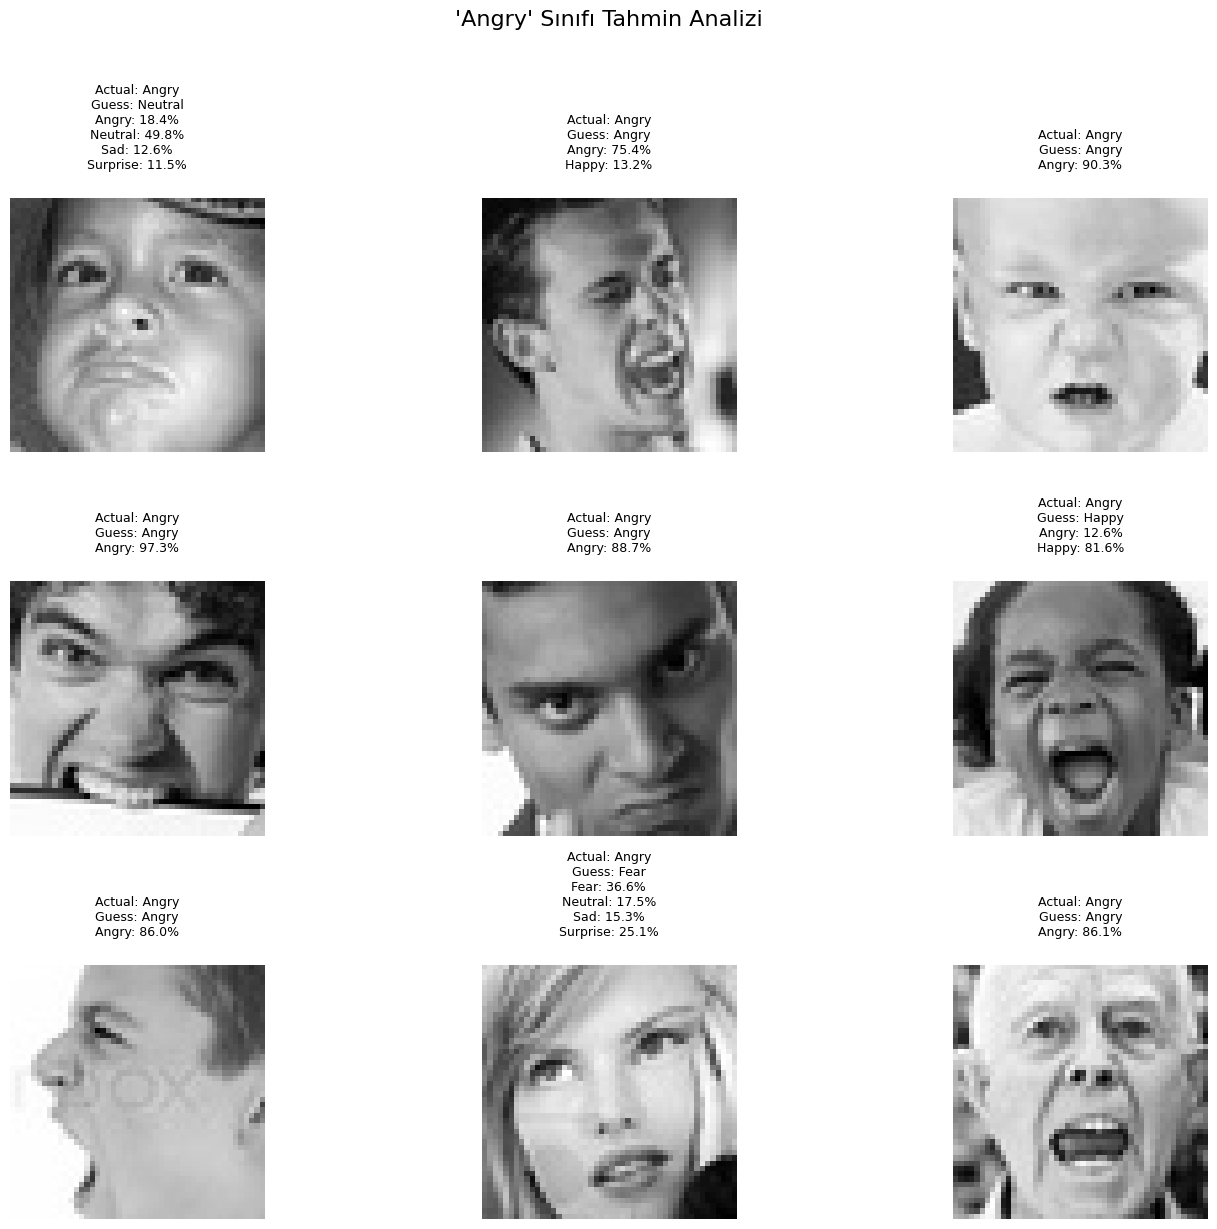


Analiz Sonuçları - Disgust:
Toplam Örnek: 111
Doğru Tahmin: 57 (%51.4)
Yanlış Tahmin: 54


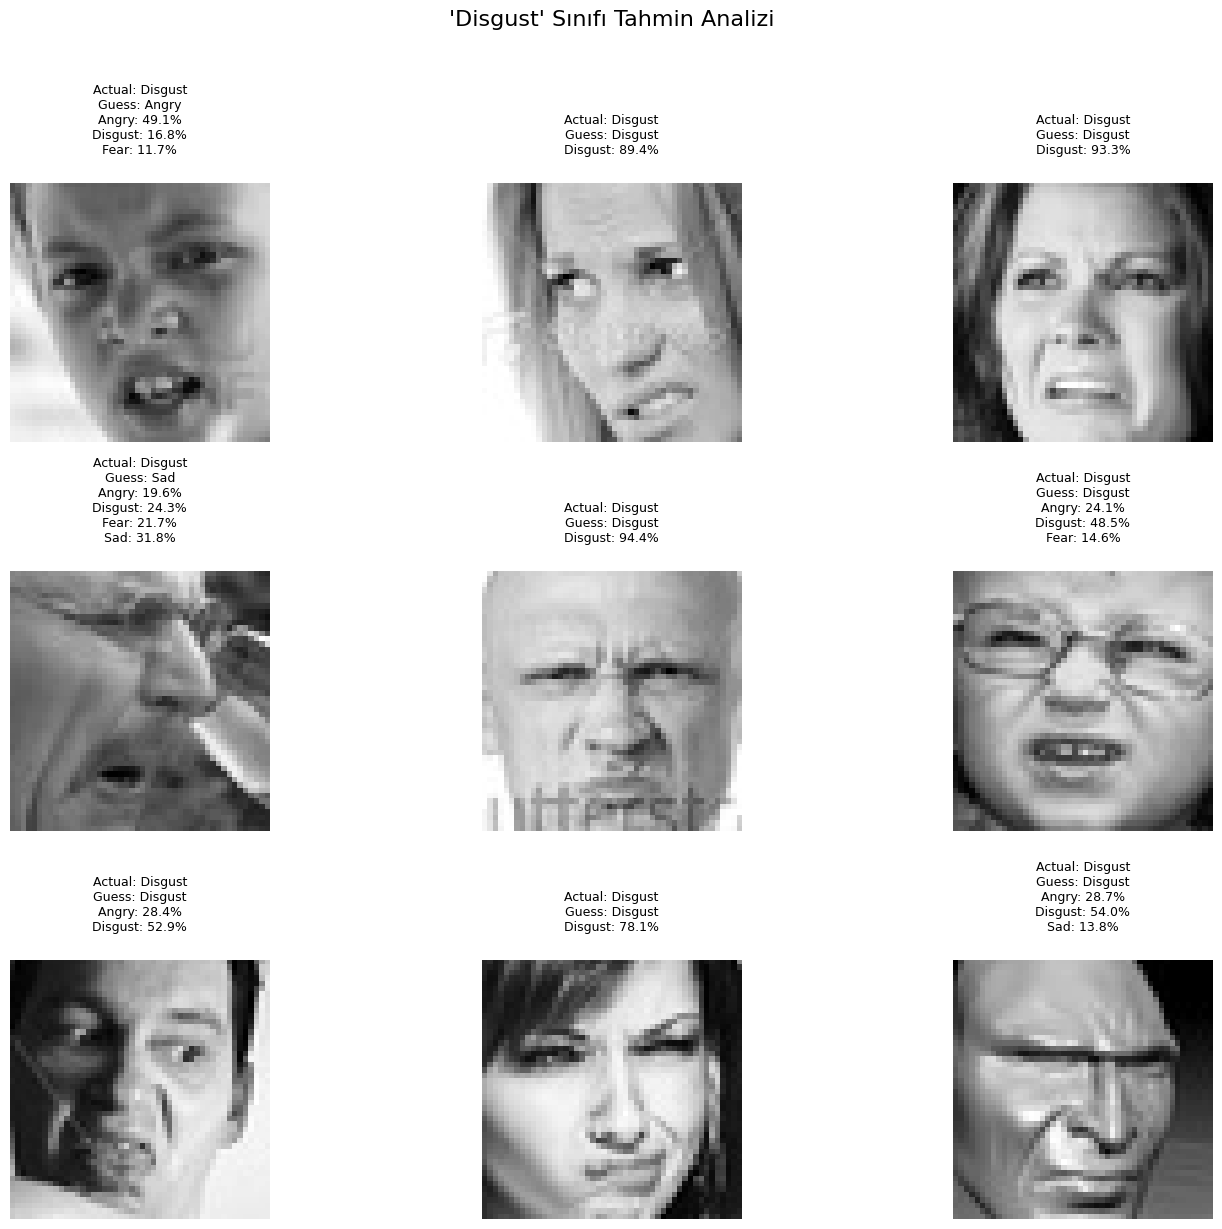


Analiz Sonuçları - Fear:
Toplam Örnek: 1024
Doğru Tahmin: 409 (%39.9)
Yanlış Tahmin: 615


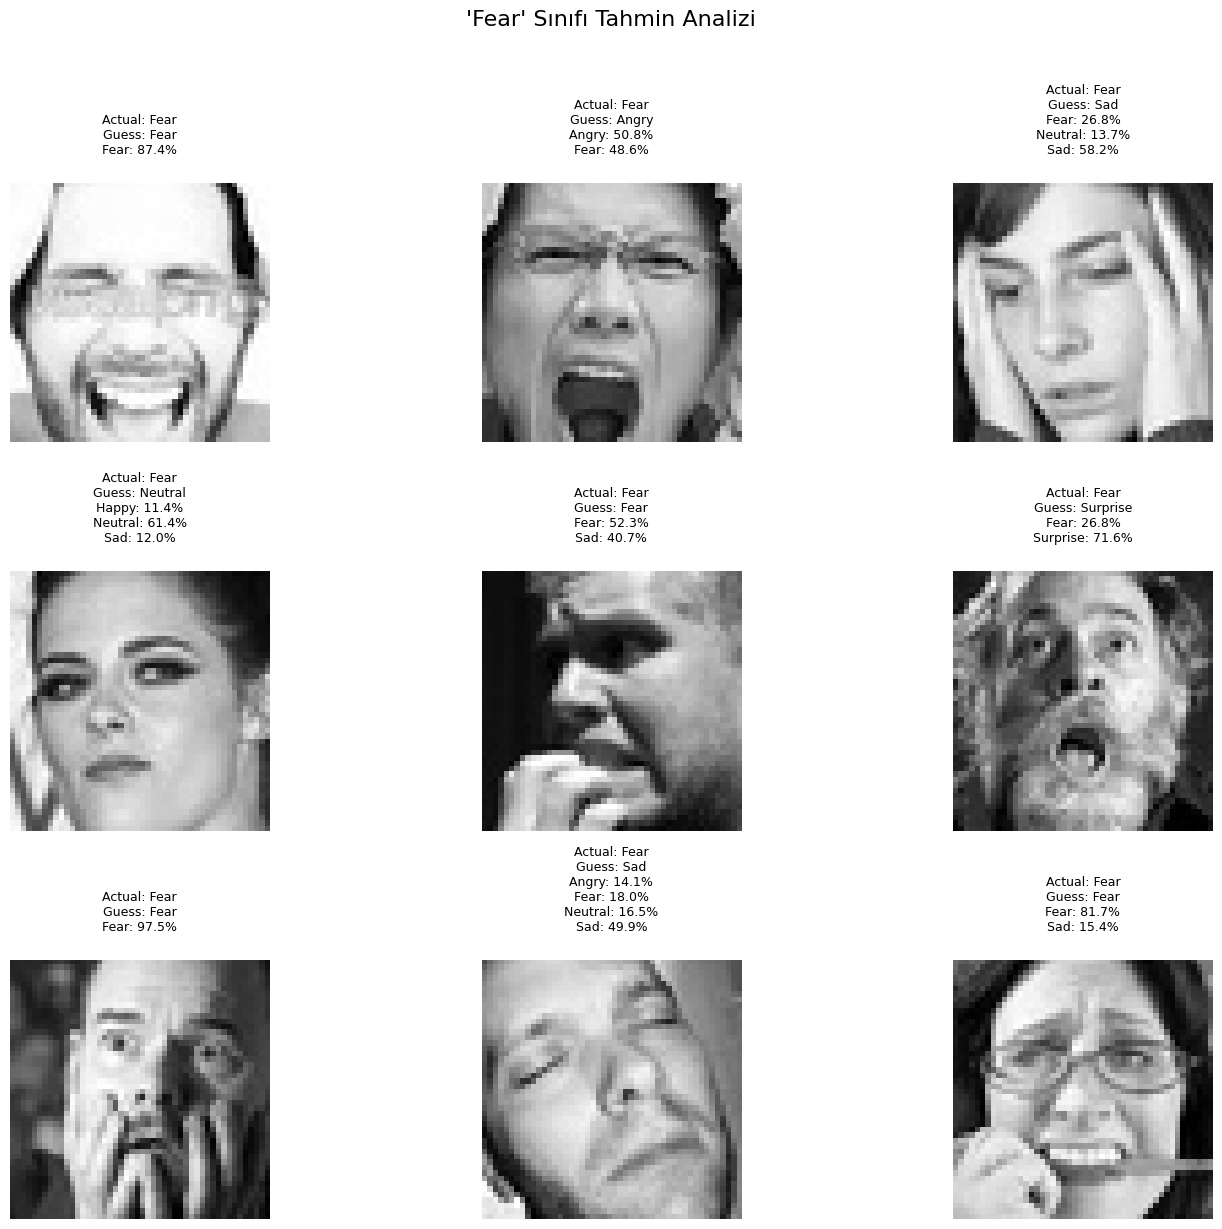


Analiz Sonuçları - Happy:
Toplam Örnek: 1774
Doğru Tahmin: 1549 (%87.3)
Yanlış Tahmin: 225


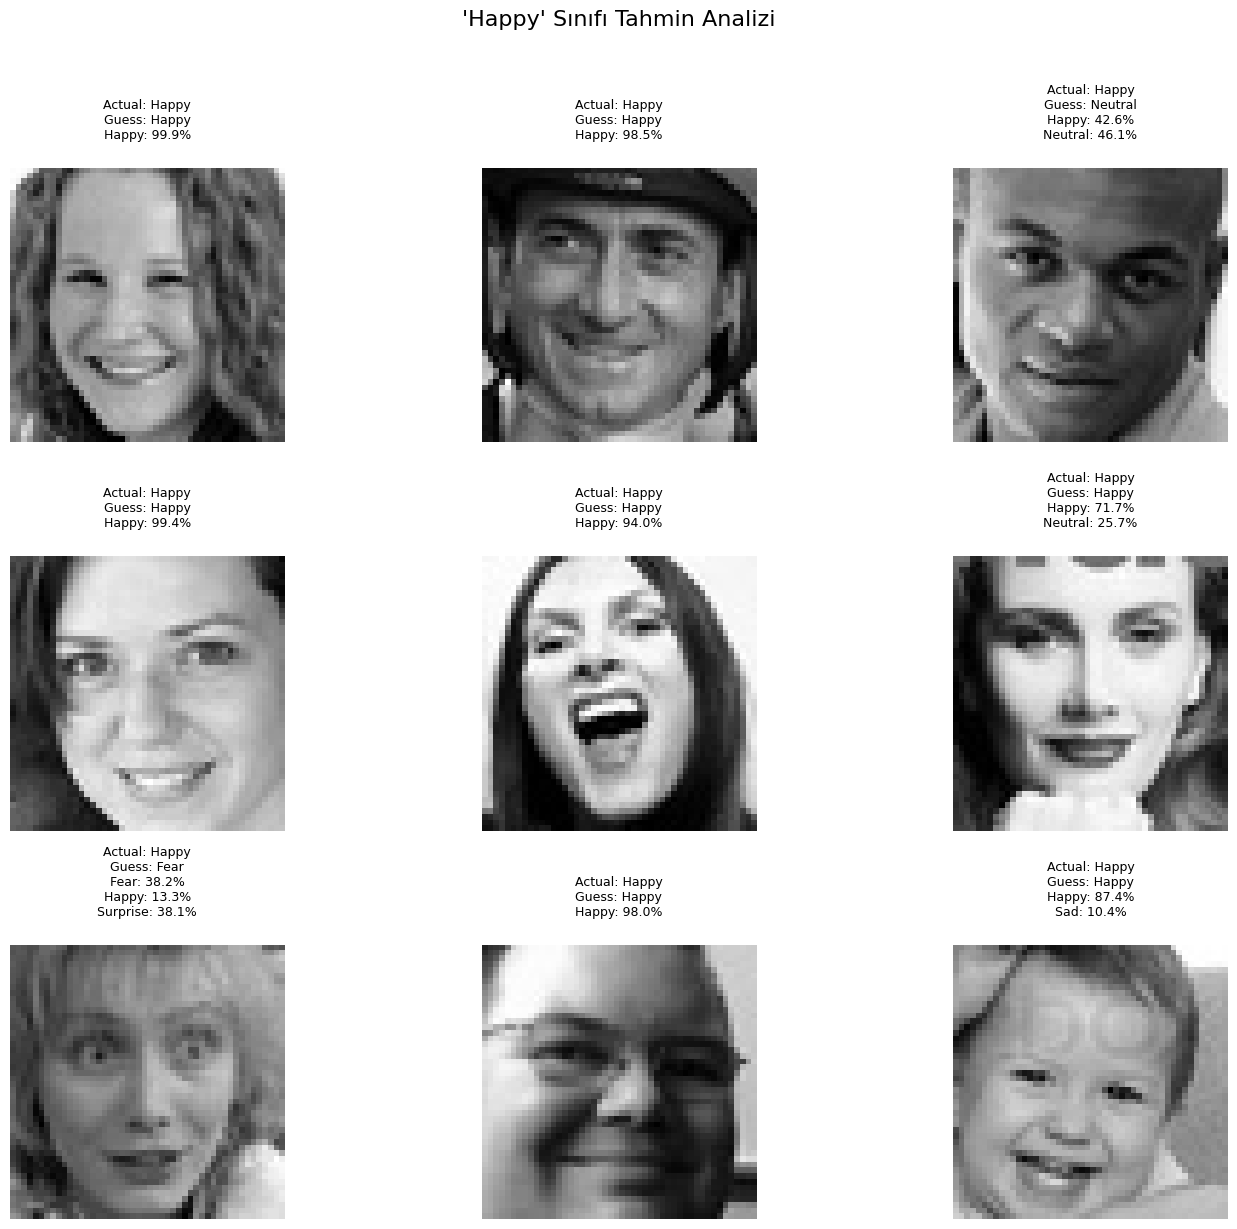


Analiz Sonuçları - Sad:
Toplam Örnek: 1247
Doğru Tahmin: 700 (%56.1)
Yanlış Tahmin: 547


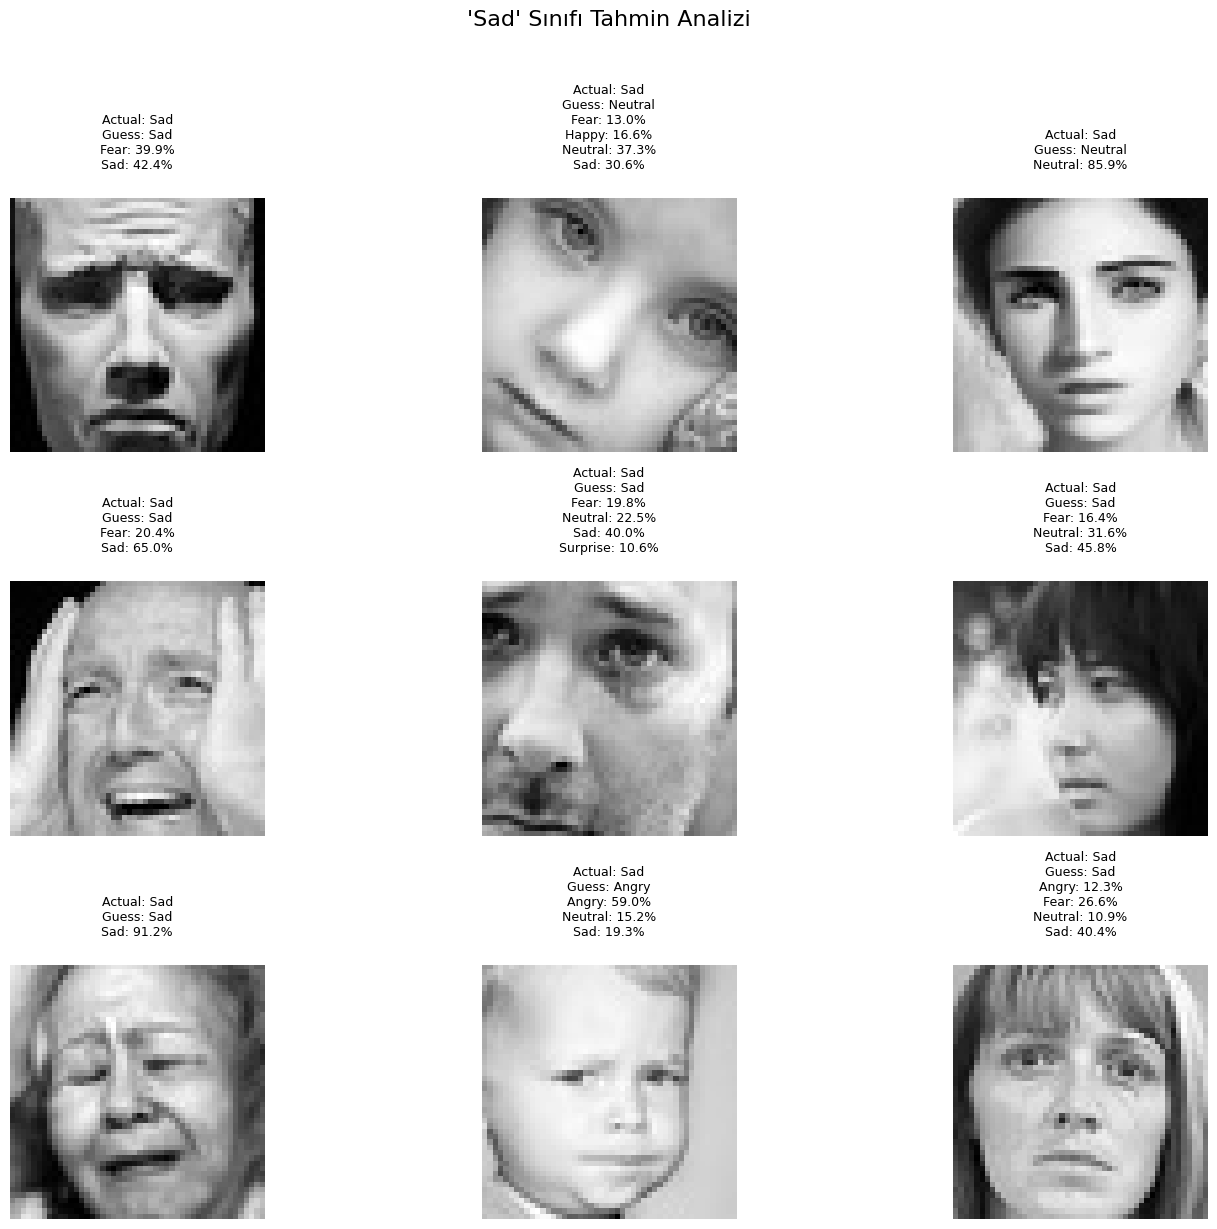


Analiz Sonuçları - Surprise:
Toplam Örnek: 831
Doğru Tahmin: 675 (%81.2)
Yanlış Tahmin: 156


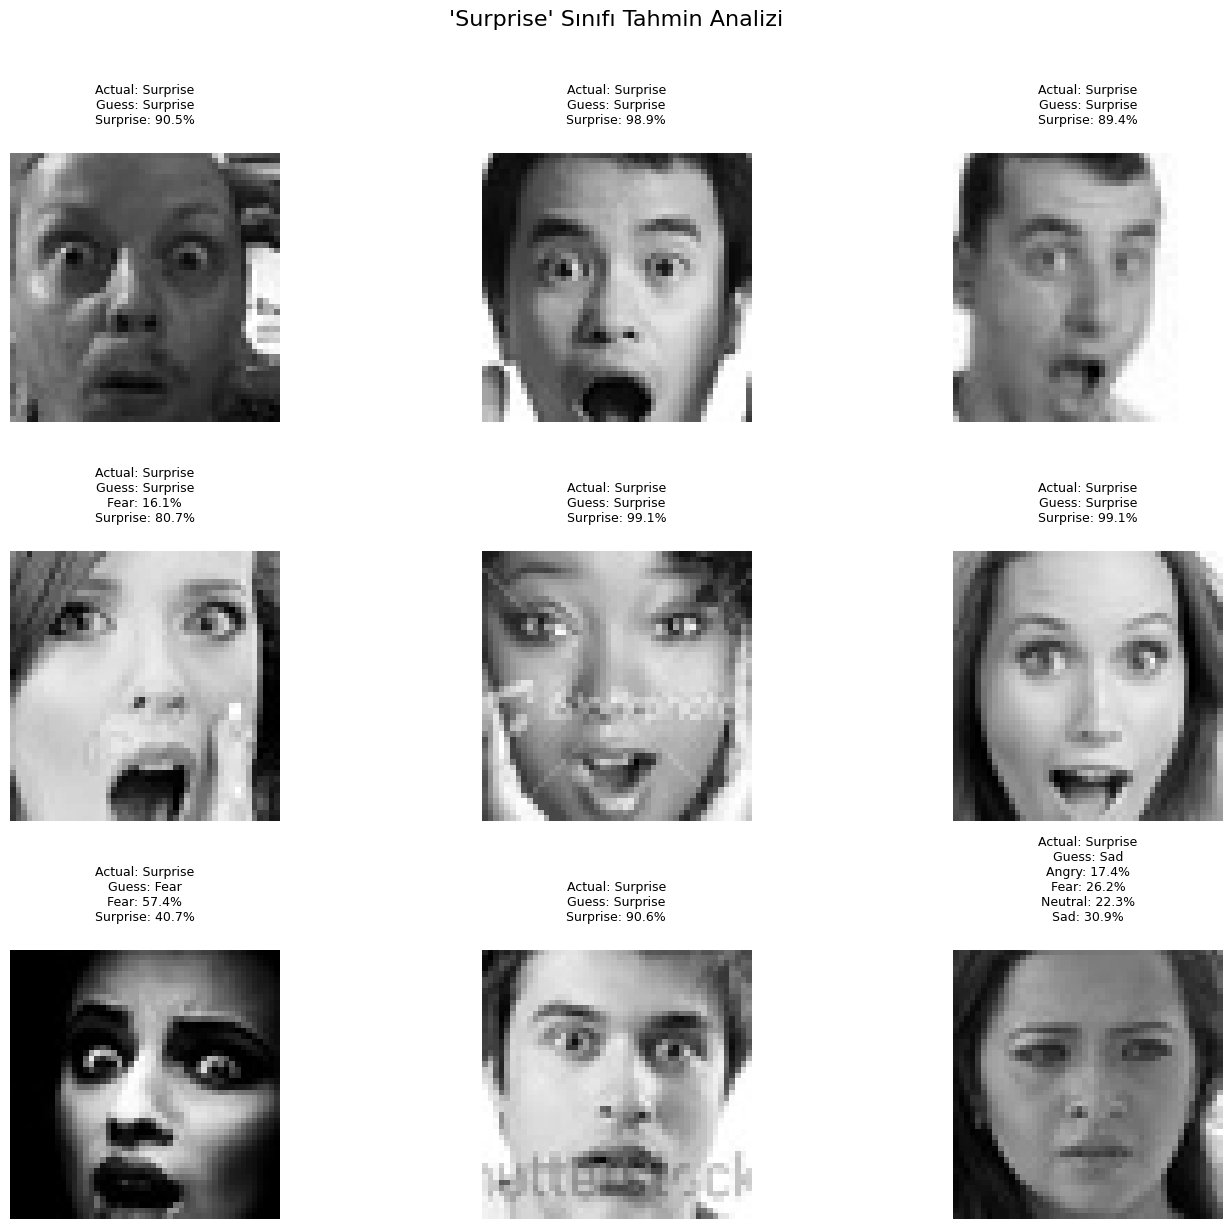


Analiz Sonuçları - Neutral:
Toplam Örnek: 1233
Doğru Tahmin: 826 (%67.0)
Yanlış Tahmin: 407


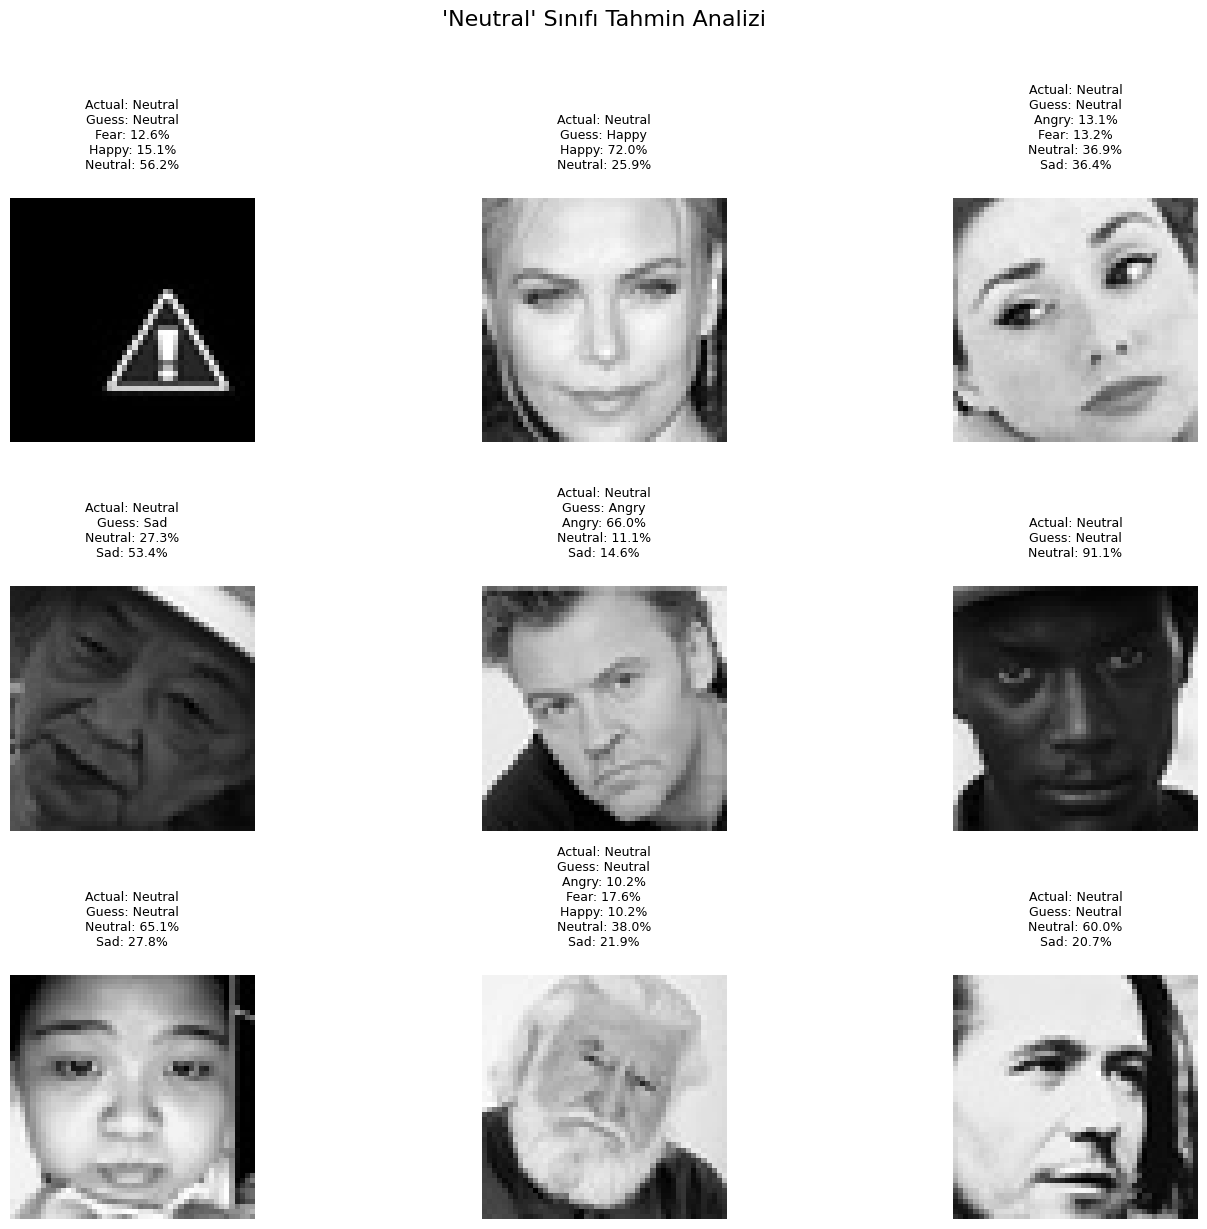

In [172]:
# Belirli bir sınıf için analiz yap
analyze_specific_class("Angry")  # Neutral sınıfını analiz et
analyze_specific_class("Disgust")  # Surprise sınıfını analiz et
analyze_specific_class("Fear")  # Neutral sınıfını analiz et
analyze_specific_class("Happy")
analyze_specific_class("Sad")  # Neutral sınıfını analiz et
analyze_specific_class("Surprise")
analyze_specific_class("Neutral")